In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, interactive
from scipy.optimize import curve_fit
from scipy.special import gamma
from sklearn.mixture import GaussianMixture

# %matplotlib inline

In [2]:
# Load the data (assuming CSV format; adjust read method if needed)
data_path = "../data/cps_clean_v2.csv"
df = pd.read_csv(data_path)

In [3]:
# Extract x and y variables from the dataframe
x = df['INCPER']
y = df['INCPER_DELTA']

# Define moving window parameters: window width = 0.02 (±0.01 around center)
window_width = 0.02
half_window = window_width / 2

# Define grid points along the x-axis
grid_points = np.linspace(x.min(), x.max(), 200)

# Pre-allocate arrays for the median and various percentile bounds.
medians      = np.empty_like(grid_points)
b20_lower    = np.empty_like(grid_points)  # for 20% interval: lower=40th percentile
b20_upper    = np.empty_like(grid_points)  # for 20% interval: upper=60th percentile

b40_lower    = np.empty_like(grid_points)  # for 40% interval: lower=30th percentile
b40_upper    = np.empty_like(grid_points)  # for 40% interval: upper=70th percentile

b60_lower    = np.empty_like(grid_points)  # for 60% interval: lower=20th percentile
b60_upper    = np.empty_like(grid_points)  # for 60% interval: upper=80th percentile

b80_lower    = np.empty_like(grid_points)  # for 80% interval: lower=10th percentile
b80_upper    = np.empty_like(grid_points)  # for 80% interval: upper=90th percentile

b95_lower    = np.empty_like(grid_points)  # for 95% interval: lower=2.5th percentile
b95_upper    = np.empty_like(grid_points)  # for 95% interval: upper=97.5th percentile

# Loop over grid points and compute percentiles from the data within the moving window.
for i, center in enumerate(grid_points):
    mask = (x >= center - half_window) & (x <= center + half_window)
    window_data = y[mask]
    if len(window_data) > 0:
        medians[i]   = np.percentile(window_data, 50)
        b20_lower[i] = np.percentile(window_data, 50 - 20/2)   # 40th percentile
        b20_upper[i] = np.percentile(window_data, 50 + 20/2)   # 60th percentile
        
        b40_lower[i] = np.percentile(window_data, 50 - 40/2)   # 30th percentile
        b40_upper[i] = np.percentile(window_data, 50 + 40/2)   # 70th percentile
        
        b60_lower[i] = np.percentile(window_data, 50 - 60/2)   # 20th percentile
        b60_upper[i] = np.percentile(window_data, 50 + 60/2)   # 80th percentile
        
        b80_lower[i] = np.percentile(window_data, 50 - 80/2)   # 10th percentile
        b80_upper[i] = np.percentile(window_data, 50 + 80/2)   # 90th percentile
        
        b95_lower[i] = np.percentile(window_data, 50 - 95/2)   # 2.5th percentile
        b95_upper[i] = np.percentile(window_data, 50 + 95/2)   # 97.5th percentile
    else:
        medians[i]   = np.nan
        b20_lower[i] = np.nan
        b20_upper[i] = np.nan
        b40_lower[i] = np.nan
        b40_upper[i] = np.nan
        b60_lower[i] = np.nan
        b60_upper[i] = np.nan
        b80_lower[i] = np.nan
        b80_upper[i] = np.nan
        b95_lower[i] = np.nan
        b95_upper[i] = np.nan

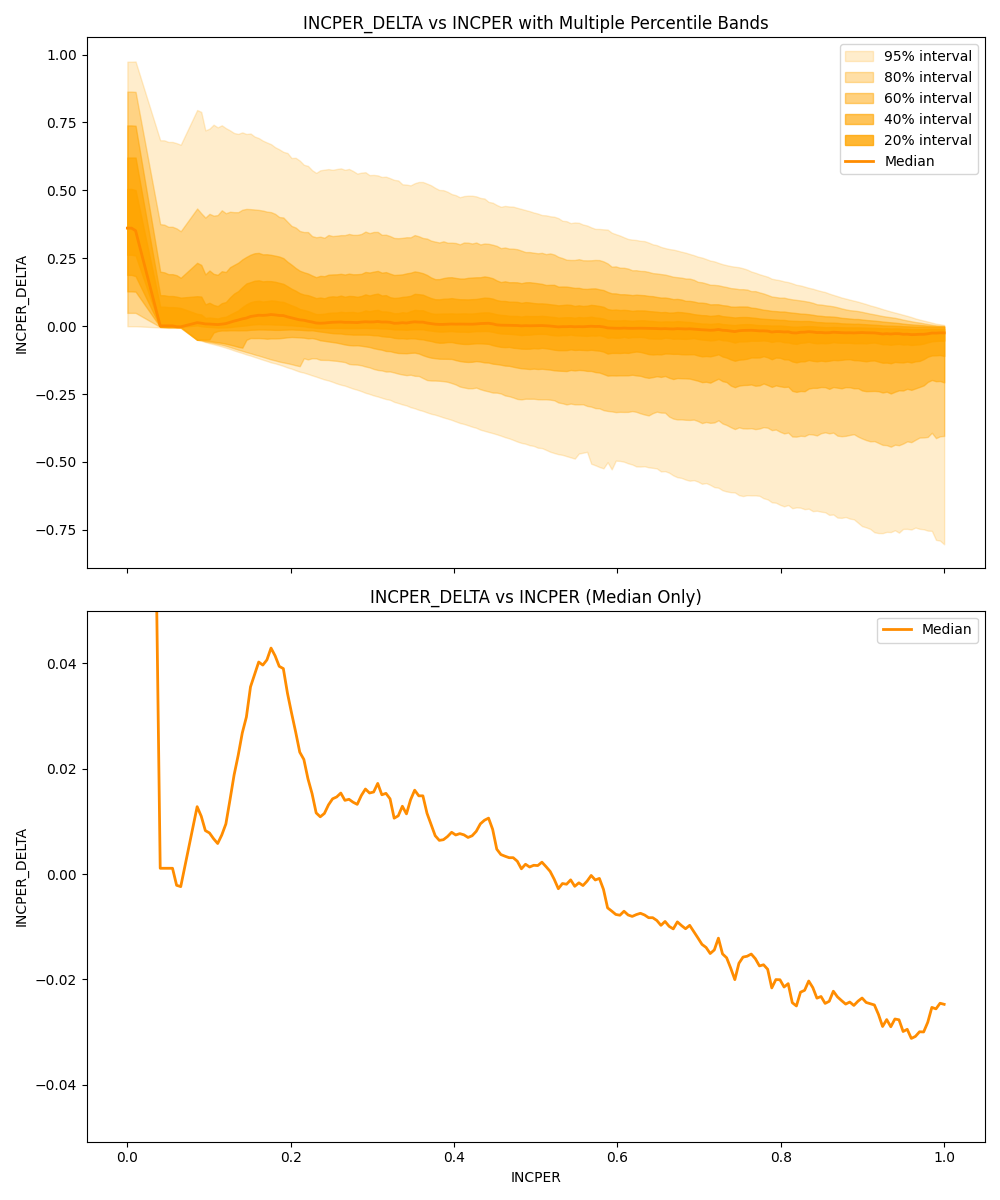

In [4]:
# Remove grid points with no data.
valid = ~np.isnan(medians)
grid_points = grid_points[valid]
medians     = medians[valid]
b20_lower   = b20_lower[valid]
b20_upper   = b20_upper[valid]
b40_lower   = b40_lower[valid]
b40_upper   = b40_upper[valid]
b60_lower   = b60_lower[valid]
b60_upper   = b60_upper[valid]
b80_lower   = b80_lower[valid]
b80_upper   = b80_upper[valid]
b95_lower   = b95_lower[valid]
b95_upper   = b95_upper[valid]

# Set up two subplots sharing the x-axis.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Top subplot: Plot the median along with nested percentile bands.
# Plot the outermost band first so that inner bands (darker) overlay cleanly.
axes[0].fill_between(grid_points, b95_lower, b95_upper, color='orange', alpha=0.2, label='95% interval')
axes[0].fill_between(grid_points, b80_lower, b80_upper, color='orange', alpha=0.35, label='80% interval')
axes[0].fill_between(grid_points, b60_lower, b60_upper, color='orange', alpha=0.5, label='60% interval')
axes[0].fill_between(grid_points, b40_lower, b40_upper, color='orange', alpha=0.65, label='40% interval')
axes[0].fill_between(grid_points, b20_lower, b20_upper, color='orange', alpha=0.8, label='20% interval')

# Then overlay the median (use a darker hue for contrast).
axes[0].plot(grid_points, medians, color='darkorange', linewidth=2, label='Median')

axes[0].set_title('INCPER_DELTA vs INCPER with Multiple Percentile Bands')
axes[0].set_ylabel('INCPER_DELTA')
axes[0].legend()

# Bottom subplot: Plot only the median line.
axes[1].plot(grid_points, medians, color='darkorange', linewidth=2, label='Median')
axes[1].set_title('INCPER_DELTA vs INCPER (Median Only)')
axes[1].set_xlabel('INCPER')
axes[1].set_ylabel('INCPER_DELTA')
plt.ylim(top=0.05)
axes[1].legend()

plt.tight_layout()
plt.show()

In [5]:
# Define grouping bins for INCPER (0 to 1 in steps of 0.01 → 100 groups)
incper_bins   = np.arange(0, 1.01, 0.01)              # 101 edges for 100 groups
incper_centers= (incper_bins[:-1] + incper_bins[1:]) / 2

# Define histogram bins for INCPER_DELTA (-1 to 1 in steps of 0.01 → 200 bins)
delta_bins    = np.linspace(-1, 1, 401)                
delta_centers = (delta_bins[:-1] + delta_bins[1:]) / 2  
bin_width_delta = delta_bins[1] - delta_bins[0]  # 0.01
bin_width_incper= incper_bins[1] - incper_bins[0]  # 0.01

C:\Users\nickb\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


KeyboardInterrupt: 

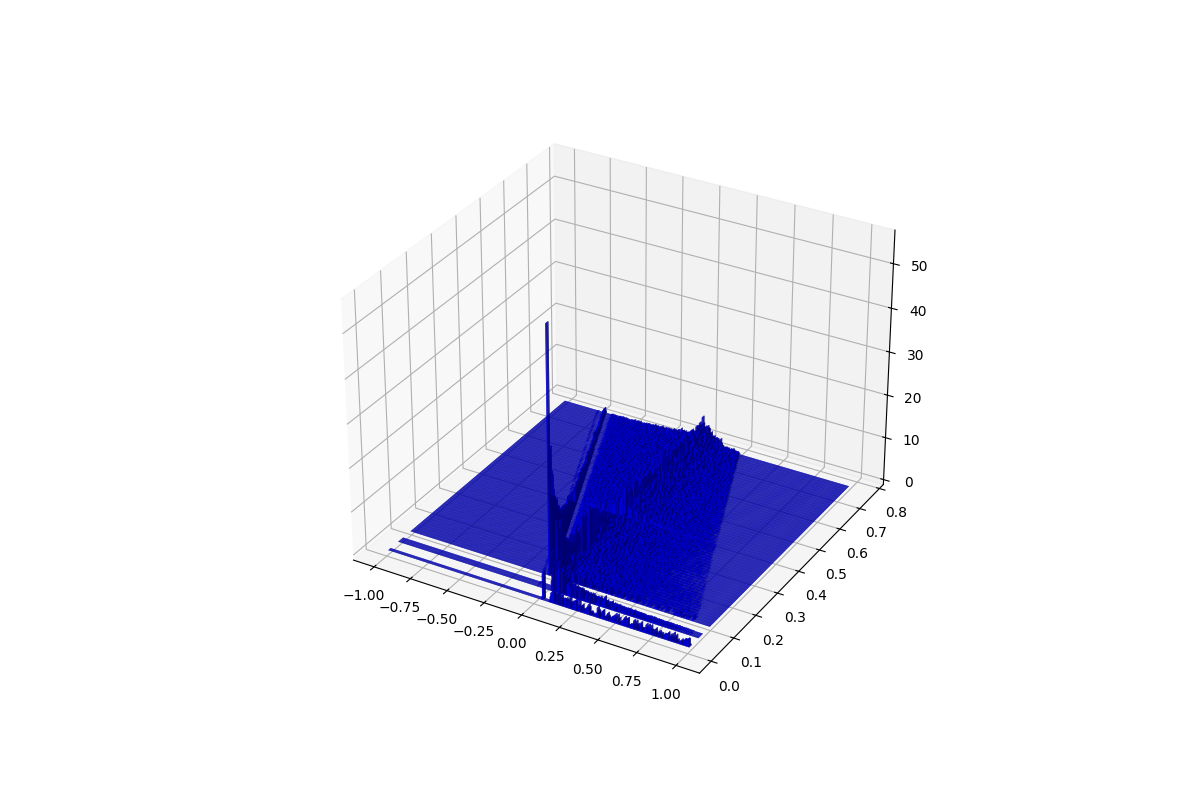

In [6]:
# Create new figure for 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over each INCPER group and compute histogram of INCPER_DELTA using density,
# omitting points where (|INCPER_DELTA| < 0.01) if INCPER is less than 0.06.
for i in range(len(incper_centers)):
    # Select data for the current INCPER group (half-open interval)
    group_df = df[(df['INCPER'] >= incper_bins[i]) & (df['INCPER'] < incper_bins[i+1])]
    # Omit data points if INCPER is less than 0.06 and INCPER_DELTA is between -0.01 and 0.01
    if incper_centers[i] < 0.06:
        group_df = group_df[~((group_df['INCPER_DELTA'] > -0.01) & (group_df['INCPER_DELTA'] < 0.01))]
    group_data = group_df['INCPER_DELTA']
    # Compute histogram as a density rather than a frequency
    density, _ = np.histogram(group_data, bins=delta_bins, density=True)
    # Plot each bar using the computed density
    for j, dens in enumerate(density):
        ax.bar3d(delta_centers[j], incper_centers[i], 0,
                 bin_width_delta, bin_width_incper, dens,
                 color='blue', alpha=0.7)

ax.set_xlabel('INCPER_DELTA')
ax.set_ylabel('INCPER')
ax.set_zlabel('Density')
ax.set_title('3D Histogram of INCPER_DELTA for INCPER Groups')
plt.show()

In [ ]:
def plot_histogram(group_index):
    lower_bound = incper_bins[group_index]
    upper_bound = incper_bins[group_index+1]
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    # Compute density instead of frequency.
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    plt.figure(figsize=(10,6))
    plt.bar(delta_centers, density_values, width=bin_width_delta, color='blue', alpha=0.7)
    plt.xlabel("INCPER_DELTA")
    plt.ylabel("Density")
    plt.title(f"Histogram Density of INCPER_DELTA for INCPER in range [{lower_bound:.2f}, {upper_bound:.2f})")
    plt.xlim(-1, 1)
    plt.show()

interact(plot_histogram, group_index=(0, len(incper_centers)-1, 1))

In [ ]:
# New helper function to define the Asymmetric Generalized Gaussian PDF
def agg_pdf(x, mu, alpha1, alpha2, beta):
    norm = beta / ((alpha1 + alpha2) * gamma(1/beta))
    x = np.array(x)
    return np.where(x < mu,
                    norm * np.exp(-((mu - x) / alpha1) ** beta),
                    norm * np.exp(-((x - mu) / alpha2) ** beta))

# Modified plot_histogram function with curve fitting:
def plot_histogram(group_index):
    lower_bound = incper_bins[group_index]
    upper_bound = incper_bins[group_index+1]
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    # Compute density histogram over delta_bins
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    plt.figure(figsize=(10,6))
    plt.bar(delta_centers, density_values, width=bin_width_delta, color='blue', alpha=0.7, label="Density Histogram")
    
    # --- Fit the Asymmetric Generalized Gaussian distribution ---
    try:
        # Initial guess for mu is the median
        mu_init = 0
        # mu_init = group_data.median()
        left_data = group_data[group_data < mu_init]
        alpha1_init = np.std(left_data) if len(left_data) > 0 else np.std(group_data)/2
        right_data = group_data[group_data >= mu_init]
        alpha2_init = np.std(right_data) if len(right_data) > 0 else np.std(group_data)/2
        beta_init = 0.7
        
        p0 = [mu_init, alpha1_init, alpha2_init, beta_init]
        bounds = ([-1, 1e-6, 1e-6, 0.1], [1, np.inf, np.inf, 10])
        
        # Only use nonzero density values for curve fitting
        valid = (delta_centers >= -upper_bound) & (delta_centers <= (1 - lower_bound))
        # valid = density_values > 0
        x_fit_data = delta_centers[valid]
        y_fit_data = density_values[valid]
        
        popt, _ = curve_fit(agg_pdf, x_fit_data, y_fit_data, p0=p0, bounds=bounds)
        
        x_fit = np.linspace(-1, 1, 500)
        y_fit = agg_pdf(x_fit, *popt)
        plt.plot(x_fit, y_fit, color='red', linewidth=2, label="AGGD Fit")
    except Exception as e:
        print("Curve fit failed:", e)
    
    plt.xlabel("INCPER_DELTA")
    plt.ylabel("Density")
    plt.title(f"Histogram Density of INCPER_DELTA for INCPER in range [{lower_bound:.2f}, {upper_bound:.2f})")
    plt.xlim(-1, 1)
    plt.legend()
    plt.show()

# (The interact call remains the same.)
interact(plot_histogram, group_index=(0, len(incper_centers)-1, 1))

In [ ]:
print((0, len(incper_centers)-1, 1))

In [ ]:
# Mixture model: weighted sum of two AGGD curves.
def agg_mix_pdf(x, mu1, a11, a21, beta1, mu2, a12, a22, beta2, pi):
    return pi * agg_pdf(x, mu1, a11, a21, beta1) + (1 - pi) * agg_pdf(x, mu2, a12, a22, beta2)

def plot_histogram_mix(group_index):
    # Define INCPER bounds for this group.
    lower_bound = incper_bins[group_index]
    upper_bound = incper_bins[group_index+1]
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    
    # Compute density histogram over 200 bins between -1 and 1.
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    plt.figure(figsize=(10,6))
    plt.bar(delta_centers, density_values, width=bin_width_delta, color='blue', alpha=0.7, label="Histogram Density")
    
    # Retain only bins with nonzero density.
    # valid = density_values > 0
    valid = (delta_centers >= -upper_bound) & (delta_centers <= (1 - lower_bound))
    if valid.sum() < 2:
        plt.title(f"Not enough nonzero bins for INCPER group {group_index}")
        plt.xlabel("INCPER_DELTA")
        plt.ylabel("Density")
        plt.show()
        return
    x_data = delta_centers[valid]
    y_data = density_values[valid]
    
    # Initial guesses for the main component (component 1) from the data.
    if len(group_data) > 0:
        mu1_init = 0
    else:
        mu1_init = 0
    left_data = group_data[group_data < mu1_init]
    right_data = group_data[group_data >= mu1_init]
    a11_init = np.std(left_data) if len(left_data) > 0 else (np.std(group_data)/2 if len(group_data) > 0 else 0.1)
    a21_init = np.std(right_data) if len(right_data) > 0 else (np.std(group_data)/2 if len(group_data) > 0 else 0.1)
    beta1_init = 0.7

    # Initial guesses for the secondary (narrow) component.
    # Here we assume the secondary peak is around 0.04, with small width.
    mu2_init = 0.04 - lower_bound
    a12_init = 0.005
    a22_init = 0.005
    beta2_init = 0.5

    # Guess that the main component carries most of the weight.
    pi_init = 0.8  

    p0 = [mu1_init, a11_init, a21_init, beta1_init, 
          mu2_init, a12_init, a22_init, beta2_init, pi_init]
    bounds_lower = [-1, 1e-6, 1e-6, 0.1, -1, 1e-6, 1e-6, 0.1, 0.0]
    bounds_upper = [1, np.inf, np.inf, 10, 1, np.inf, np.inf, 10, 1.0]
    
    try:
        popt, _ = curve_fit(agg_mix_pdf, x_data, y_data, p0=p0, bounds=(bounds_lower, bounds_upper))
        # Evaluate the fitted mixture on a smooth grid.
        x_fit = np.linspace(-1, 1, 500)
        y_fit = agg_mix_pdf(x_fit, *popt)
        # Also calculate the individual components.
        comp1 = popt[8] * agg_pdf(x_fit, popt[0], popt[1], popt[2], popt[3])
        comp2 = (1 - popt[8]) * agg_pdf(x_fit, popt[4], popt[5], popt[6], popt[7])
        
        plt.plot(x_fit, y_fit, color='red', linewidth=2, label="Mixture Fit")
        plt.plot(x_fit, comp1, color='magenta', linestyle='--', linewidth=1.5, label="Component 1")
        plt.plot(x_fit, comp2, color='green', linestyle='--', linewidth=1.5, label="Component 2")
    except Exception as e:
        print("Mixture model fit failed for INCPER group", group_index, ":", e)
    
    plt.xlabel("INCPER_DELTA")
    plt.ylabel("Density")
    plt.title(f"Histogram & Mixture Fit for INCPER Range [{lower_bound:.2f}, {upper_bound:.2f})")
    plt.xlim(-1, 1)
    plt.legend()
    plt.show()

# Create interactive slider for the INCPER groups.
interact(plot_histogram_mix, group_index=(0, len(incper_centers)-1, 1))

In [ ]:
results = []

for i in range(len(incper_centers)):
    lower_bound = incper_bins[i]
    upper_bound = incper_bins[i+1]
    group_center = incper_centers[i]
    
    # Select the INCPER_DELTA data corresponding to the current INCPER group.
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    if group_data.empty or len(group_data) < 5:
        # Not enough data; save NaNs.
        results.append({
            "group_index": i,
            "incper_lower": lower_bound,
            "incper_upper": upper_bound,
            "incper_center": group_center,
            "mu1": np.nan, "alpha11": np.nan, "alpha21": np.nan, "beta1": np.nan,
            "mu2": np.nan, "alpha12": np.nan, "alpha22": np.nan, "beta2": np.nan,
            "pi": np.nan, "mse": np.nan
        })
        continue

    # Compute the density histogram (200 bins between -1 and 1)
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    # Valid bins: only use bins where INCPER_DELTA is within [-upper_bound, 1 - lower_bound]
    valid = (delta_centers >= -upper_bound) & (delta_centers <= (1 - lower_bound))
    if valid.sum() < 2:
        results.append({
            "group_index": i,
            "incper_lower": lower_bound,
            "incper_upper": upper_bound,
            "incper_center": group_center,
            "mu1": np.nan, "alpha11": np.nan, "alpha21": np.nan, "beta1": np.nan,
            "mu2": np.nan, "alpha12": np.nan, "alpha22": np.nan, "beta2": np.nan,
            "pi": np.nan, "mse": np.nan
        })
        continue
    x_data = delta_centers[valid]
    y_data = density_values[valid]
    
    # ----------------------------------
    # Set up initial guesses for the mixture model.
    # Component 1 (main component) guesses:
    mu1_init = 0
    left_data = group_data[group_data < mu1_init]
    a11_init = np.std(left_data) if len(left_data) > 0 else (np.std(group_data)/2 if len(group_data)>1 else 0.1)
    right_data = group_data[group_data >= mu1_init]
    a21_init = np.std(right_data) if len(right_data) > 0 else (np.std(group_data)/2 if len(group_data)>1 else 0.1)
    beta1_init = 0.7

    # Component 2 (secondary component) guesses:
    mu2_init = 0.04 - lower_bound
    a12_init = 0.005
    a22_init = 0.005
    beta2_init = 0.7

    # Mixing weight guess:
    pi_init = 0.8

    p0 = [mu1_init, a11_init, a21_init, beta1_init,
          mu2_init, a12_init, a22_init, beta2_init, pi_init]
    
    # ----------------------------------
    # Set parameter bounds.
    # For mu1: allow full range.
    # For mu2: force mu2 <= (0.07 - lower_bound)
    bounds_lower = [-1, 1e-6, 1e-6, 0.1, -1, 1e-6, 1e-6, 0.1, 0.0]
    mu1_upper = 1
    mu2_upper = (0.07 - lower_bound)  # force mu₂ < 0.07 - lower_bound
    bounds_upper = [1, np.inf, np.inf, 10, mu2_upper, np.inf, np.inf, 10, 1.0]
    
    try:
        popt, _ = curve_fit(agg_mix_pdf, x_data, y_data, p0=p0, bounds=(bounds_lower, bounds_upper))
        predictions = agg_mix_pdf(x_data, *popt)
        mse = np.mean((predictions - y_data)**2)
    except Exception as e:
        popt = [np.nan] * 9
        mse = np.nan
        
    results.append({
         "group_index": i,
         "incper_lower": lower_bound,
         "incper_upper": upper_bound,
         "incper_center": group_center,
         "mu1": popt[0],
         "alpha11": popt[1],
         "alpha21": popt[2],
         "beta1": popt[3],
         "mu2": popt[4],
         "alpha12": popt[5],
         "alpha22": popt[6],
         "beta2": popt[7],
         "pi": popt[8],
         "mse": mse
    })

# Create a DataFrame of all fitted parameters.
df_params = pd.DataFrame(results)
print(df_params)

In [ ]:
print(df_params[48:55])

In [ ]:
# Sort the dataframe by incper_center (if not already sorted)
df_plot = df_params.sort_values(by='incper_center')

plt.figure(figsize=(10,6))
plt.scatter(df_plot['incper_center'], df_plot['mu1'], color='blue', s=30, label='mu1')
plt.plot(df_plot['incper_center'], df_plot['mu1'], color='blue', lw=1)
plt.xlabel('INCPER Center')
plt.ylabel('mu1')
plt.title('mu1 vs INCPER Center')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# List of parameters to plot (adjust as needed)
params_list = ['mu1', 'alpha11', 'alpha21', 'beta1', 'mu2', 'alpha12', 'alpha22', 'beta2', 'pi', 'mse']

# Determine grid layout for subplots
num_params = len(params_list)
ncols = 2
nrows = int(np.ceil(num_params / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(12, nrows * 3))
axs = axs.flatten()

# Plot each parameter vs. incper_center
for i, param in enumerate(params_list):
    # Filter NaN values for a cleaner plot.
    valid = df_params[param].notna() & df_params['incper_center'].notna()
    axs[i].plot(df_params.loc[valid, 'incper_center'], df_params.loc[valid, param],
                marker='o', linestyle='-', markersize=4)
    axs[i].set_xlabel('INCPER Center')
    axs[i].set_ylabel(param)
    axs[i].set_title(param)
    axs[i].grid(True)

# Hide any extra subplots
for j in range(num_params, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()

In [ ]:
results = []

for i in range(len(incper_centers)):
    lower_bound = incper_bins[i]
    upper_bound = incper_bins[i+1]
    group_center = incper_centers[i]
    
    # Select the INCPER_DELTA data for the current INCPER group.
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    if group_data.empty:
        # Append a row of NaNs if no data exists.
        results.append({
            "group_index": i,
            "incper_lower": lower_bound,
            "incper_upper": upper_bound,
            "incper_center": group_center,
            "mu": np.nan,
            "alpha1": np.nan,
            "alpha2": np.nan,
            "beta": np.nan,
            "mse": np.nan
        })
        continue

    # Compute the density histogram for INCPER_DELTA using 200 bins from -1 to 1.
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    # Filter out histogram bins where density is zero.
    valid = density_values > 0
    if valid.sum() < 2:
        popt = [np.nan, np.nan, np.nan, np.nan]
        mse = np.nan
    else:
        # Set initial guesses:
        mu_init = 0
        left_data = group_data[group_data < mu_init]
        alpha1_init = np.std(left_data) if len(left_data) > 0 else (np.std(group_data) / 2 if len(group_data) > 1 else 0.1)
        right_data = group_data[group_data >= mu_init]
        alpha2_init = np.std(right_data) if len(right_data) > 0 else (np.std(group_data) / 2 if len(group_data) > 1 else 0.1)
        beta_init = 1
        p0 = [mu_init, alpha1_init, alpha2_init, beta_init]
        
        # Set parameter bounds:
        bounds_lower = [-1, 1e-6, 1e-6, 0.1]
        bounds_upper = [1, np.inf, np.inf, 10]
        
        try:
            popt, _ = curve_fit(agg_pdf, delta_centers[valid], density_values[valid],
                                p0=p0, bounds=(bounds_lower, bounds_upper))
            # Compute predictions using the fitted parameters, then calculate MSE.
            predictions = agg_pdf(delta_centers[valid], *popt)
            mse = np.mean((predictions - density_values[valid])**2)
        except Exception as e:
            popt = [np.nan, np.nan, np.nan, np.nan]
            mse = np.nan
    
    results.append({
         "group_index": i,
         "incper_lower": lower_bound,
         "incper_upper": upper_bound,
         "incper_center": group_center,
         "mu": popt[0],
         "alpha1": popt[1],
         "alpha2": popt[2],
         "beta": popt[3],
         "mse": mse
    })

# Create a dataframe with the collected results.
df_params = pd.DataFrame(results)
print(df_params)

In [ ]:
# Filter out rows with any missing fitted parameter values
df_filtered = df_params.dropna(subset=["mu", "alpha1", "alpha2", "beta", "mse"])
df_filtered = df_filtered[df_filtered["incper_center"] >= 0.16]
df_filtered = df_filtered[df_filtered["incper_center"] <= 0.98]

# Create a 2x2 grid plot for mu, alpha1, alpha2, beta vs. INCPER center.
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(df_filtered['incper_center'], df_filtered['mu'], 'o-', color='darkorange')
plt.xlabel("INCPER Center")
plt.ylabel("mu")
plt.title("Fitted mu vs. INCPER")

plt.subplot(2, 2, 2)
plt.plot(df_filtered['incper_center'], df_filtered['alpha1'], 'o-', color='blue')
plt.xlabel("INCPER Center")
plt.ylabel("alpha1")
plt.title("Fitted alpha1 vs. INCPER")

plt.subplot(2, 2, 3)
plt.plot(df_filtered['incper_center'], df_filtered['alpha2'], 'o-', color='green')
plt.xlabel("INCPER Center")
plt.ylabel("alpha2")
plt.title("Fitted alpha2 vs. INCPER")

plt.subplot(2, 2, 4)
plt.plot(df_filtered['incper_center'], df_filtered['beta'], 'o-', color='red')
plt.xlabel("INCPER Center")
plt.ylabel("beta")
plt.title("Fitted beta vs. INCPER")

plt.tight_layout()
plt.show()

# Plot for the mean squared error (MSE) of the fits.
plt.figure(figsize=(8, 6))
plt.plot(df_filtered['incper_center'], df_filtered['mse'], 'o-', color='purple')
plt.xlabel("INCPER Center")
plt.ylabel("MSE")
plt.title("MSE of AGGD Fit vs. INCPER")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['alpha1'], df_filtered['alpha2'], color='blue', alpha=0.7)
plt.xlabel('alpha1')
plt.ylabel('alpha2')
plt.title('Scatter Plot of alpha1 vs. alpha2')
plt.grid(True)
plt.show()

In [ ]:
global_fit_params = {}
# New helper function to define the Asymmetric Generalized Gaussian PDF
def agg_pdf(x, mu, alpha1, alpha2, beta):
    norm = beta / ((alpha1 + alpha2) * gamma(1/beta))
    x = np.array(x)
    return np.where(x < mu,
                    norm * np.exp(-((mu - x) / alpha1) ** beta),
                    norm * np.exp(-((x - mu) / alpha2) ** beta))

# Modified plot_histogram function with curve fitting:
def plot_histogram(group_index):
    lower_bound = incper_bins[group_index]
    upper_bound = incper_bins[group_index+1]
    group_data = df[(df['INCPER'] >= lower_bound) & (df['INCPER'] < upper_bound)]['INCPER_DELTA']
    # Compute density histogram over delta_bins
    density_values, _ = np.histogram(group_data, bins=delta_bins, density=True)
    
    plt.figure(figsize=(10,6))
    plt.bar(delta_centers, density_values, width=bin_width_delta, color='blue', alpha=0.7, label="Density Histogram")
    
    # --- Fit the Asymmetric Generalized Gaussian distribution ---
    try:
        # Initial guess for mu is the median
        mu_init = group_data.median()
        left_data = group_data[group_data < mu_init]
        alpha1_init = np.std(left_data) if len(left_data) > 0 else np.std(group_data)/2
        right_data = group_data[group_data >= mu_init]
        alpha2_init = np.std(right_data) if len(right_data) > 0 else np.std(group_data)/2
        beta_init = 2.0   # Common starting guess
        
        p0 = [mu_init, alpha1_init, alpha2_init, beta_init]
        bounds = ([-1, 1e-6, 1e-6, 0.1], [1, np.inf, np.inf, 10])
        
        # Only use nonzero density values for curve fitting
        valid = density_values > 0
        x_fit_data = delta_centers[valid]
        y_fit_data = density_values[valid]
        
        popt, _ = curve_fit(agg_pdf, x_fit_data, y_fit_data, p0=p0, bounds=bounds)
        
        # Save the fitted parameters into the global dictionary.
        global global_fit_params
        global_fit_params[group_index] = {"lower_bound": lower_bound,
                                          "upper_bound": upper_bound,
                                          "mu": popt[0],
                                          "alpha1": popt[1],
                                          "alpha2": popt[2],
                                          "beta": popt[3]}
        # Convert to DataFrame and optionally print the parameters.
        params_df = pd.DataFrame.from_dict(global_fit_params, orient='index')
        print("Fitted parameters for each INCPER group so far:")
        print(params_df)
        
        x_fit = np.linspace(-1, 1, 500)
        y_fit = agg_pdf(x_fit, *popt)
        plt.plot(x_fit, y_fit, color='red', linewidth=2, label="AGGD Fit")
    except Exception as e:
        print("Curve fit failed:", e)
    
    plt.xlabel("INCPER_DELTA")
    plt.ylabel("Density")
    plt.title(f"Histogram Density of INCPER_DELTA for INCPER in range [{lower_bound:.2f}, {upper_bound:.2f})")
    plt.xlim(-1, 1)
    plt.legend()
    plt.show()

# (The interact call remains the same.)
interact(plot_histogram, group_index=(0, len(incper_centers)-1, 1))

In [ ]:
# Create new figure for 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over each INCPER group and compute histogram of INCPER_DELTA
for i in range(len(incper_centers)):
    # Select data for current INCPER group (using half-open intervals)
    group_data = df[(df['INCPER'] >= incper_bins[i]) & (df['INCPER'] < incper_bins[i+1])]['INCPER_DELTA']
    # Compute histogram using the specified delta bins
    counts, _ = np.histogram(group_data, bins=delta_bins)
    # For each delta bin, draw a 3D bar: x-axis = INCPER_DELTA, y-axis = INCPER group, z-axis = frequency
    for j, count in enumerate(counts):
        ax.bar3d(delta_centers[j], incper_centers[i], 0,
                 bin_width_delta, bin_width_incper, count,
                 color='blue', alpha=0.7)

ax.set_xlabel('INCPER_DELTA')
ax.set_ylabel('INCPER')
ax.set_zlabel('Frequency')
ax.set_title('3D Histogram of INCPER_DELTA for INCPER Groups')
plt.show()

In [ ]:
# Define a tolerance for selecting values "around 0"
tolerance = 0.005

# Compute the frequency for each INCPER group where INCPER_DELTA is near 0
cross_section_counts = []
for i in range(len(incper_centers)):
    # Group data for the current INCPER bin
    group = df[(df['INCPER'] >= incper_bins[i]) & (df['INCPER'] < incper_bins[i+1])]
    # Count data points where INCPER_DELTA is within ±tolerance (i.e. cross section at 0)
    count = group[(group['INCPER_DELTA'] >= -tolerance) & (group['INCPER_DELTA'] < tolerance)].shape[0]
    cross_section_counts.append(count)

# Plot the cross section as a bar plot with x-axis ticks every 0.02
plt.figure(figsize=(10, 6))
plt.bar(incper_centers, cross_section_counts, width=0.01, color='green', alpha=0.7)
plt.xlabel('INCPER')
plt.ylabel('Frequency')
plt.title('Cross Section at INCPER_DELTA = 0 (|delta| < 0.005)')
plt.xticks(np.arange(0, 1.01, 0.02))  # set ticks from 0 to 1 with a step of 0.02
plt.xlim(right=0.1)
plt.tight_layout()
plt.show()

In [ ]:
# Define a tolerance for the INCPER cross section slice
tolerance = 0.005

# Filter the data for INCPER values near 0.055
incper_val = 0.055
slice_df = df[(df['INCPER'] >= incper_val - tolerance) & (df['INCPER'] < incper_val + tolerance)]

# Compute histogram of INCPER_DELTA for this cross section using the pre-defined delta_bins
hist_counts, _ = np.histogram(slice_df['INCPER_DELTA'], bins=delta_bins)

# Plot the cross section histogram as a 2D bar plot
plt.figure(figsize=(10, 6))
plt.bar(delta_centers, hist_counts, width=bin_width_delta, color='purple', alpha=0.7)
plt.xlabel('INCPER_DELTA')
plt.ylabel('Frequency')
plt.title(f'Cross Section at INCPER = {incper_val} (|INCPER - {incper_val}| < {tolerance})')
plt.xticks(np.arange(-1, 1.01, 0.01))
plt.xlim(left = -0.05, right=0.1)
plt.tight_layout()
plt.show()

In [ ]:
# Use AGE as the independent variable and INCPER_DELTA as the dependent variable.
x = df['AGE']
y = df['INCPER_DELTA']

# Define the moving window size. Here we use a 5-year window (±2.5 years).
window_width = 5
half_window = window_width / 2

# Create grid points covering the range of AGE
grid_points = np.linspace(x.min(), x.max(), 200)

# Initialize arrays to store the moving median and the 16th and 84th percentiles.
medians = np.empty_like(grid_points)
lower_percentile = np.empty_like(grid_points)
upper_percentile = np.empty_like(grid_points)

for i, center in enumerate(grid_points):
    # Select data within the window centered at this grid point.
    mask = (x >= center - half_window) & (x <= center + half_window)
    window_data = y[mask]
    if len(window_data) > 0:
        medians[i] = np.percentile(window_data, 50)       # Median
        lower_percentile[i] = np.percentile(window_data, 16)  # 16th percentile
        upper_percentile[i] = np.percentile(window_data, 84)   # 84th percentile
    else:
        medians[i] = np.nan
        lower_percentile[i] = np.nan
        upper_percentile[i] = np.nan

# Remove grid points with no data.
valid = ~np.isnan(medians)
grid_points = grid_points[valid]
medians = medians[valid]
lower_percentile = lower_percentile[valid]
upper_percentile = upper_percentile[valid]

# Create two vertically aligned subplots sharing the same x-axis.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Top subplot: Median with a shaded region indicating the 16th–84th percentiles.
axes[0].plot(grid_points, medians, color='orange', label='Median of INCPER_DELTA')
axes[0].fill_between(grid_points, lower_percentile, upper_percentile, color='orange', 
                     alpha=0.3, label='16th-84th Percentile Range')
axes[0].set_title('INCPER_DELTA vs AGE with 16th-84th Percentile Range')
axes[0].set_ylabel('INCPER_DELTA')
axes[0].legend()

# Bottom subplot: Median only.
axes[1].plot(grid_points, medians, color='orange', label='Median of INCPER_DELTA')
axes[1].set_title('INCPER_DELTA vs AGE (Median Only)')
axes[1].set_xlabel('AGE')
axes[1].set_ylabel('INCPER_DELTA')
axes[1].legend()

plt.tight_layout()
plt.show()